## APPLICATION OF CLUSTERING IN CARD TRANSACTION FRAUD DETECTION

## 1. INTRO

This project aims to develop a robust fraud detection system by employing a hybrid approach that combines unsupervised clustering with supervised classification. 
We will initially leverage clustering techniques to grouping transaction into different cluster/group per anomalous transaction patterns, then associate those clusters with available labeled "fraud" or "non-fraud" to predict 'suspected' or 'non-suspected' fraud case using supervised learning.

Expecting this project will able to idenfity:
1) efficiency of different algo in clustering task, with different size of dataset;
2) how to select suitable value for clustering;
3) potential of hybrid model unsupervised and supervised learning to improve performance for business beneficial.

For evaluation at unsupervised learning, for param's values selection we will use **noise ratio for DBSCAN** and **Inertia for K-Means**, then use **Silhouette Score as final metric to assess quality of 2 models**.

By this approach, we use dataset from https://github.com/Fraud-Detection-Handbook/simulated-data-transformed/blob/main/data, containing transaction data from July to September 2018, includes explicit fraud/non-fraud labels, enabling the subsequent application of supervised learning models to accurately classify "suspected" transactions. This dual-stage strategy aims to enhance fraud detection accuracy by first isolating potential anomalies and then refining the classification with a supervised model.

In [1]:
#import necessary library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import os

In [2]:
#setup display options
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.4f}'.format) #set to display max 4 values

In [3]:
#count number of data_files
_, _, files = next(os.walk('dataset')) #getting files name

#initiate the list of path
ilist = []
for i in files:
    dt = f'dataset/{i}'
    ilist.append(dt)

#instantiate Dataframe:
obj_init = pd.read_pickle(ilist[0])

#getting only index
df = obj_init.drop(obj_init.index, inplace = True)

#loading list
for il in ilist:
    obj_amd = pd.read_pickle(il)
    df = pd.concat([df, obj_amd], ignore_index=True, sort=False)

In [4]:
#quick clean
df = df.dropna()
df['TERMINAL_ID'].astype(int)
df['CUSTOMER_ID'].astype(int)

0         4984
1         4357
2         2311
3         1373
4         3908
          ... 
881355     590
881356    4077
881357     468
881358    4713
881359    4657
Name: CUSTOMER_ID, Length: 881360, dtype: int64

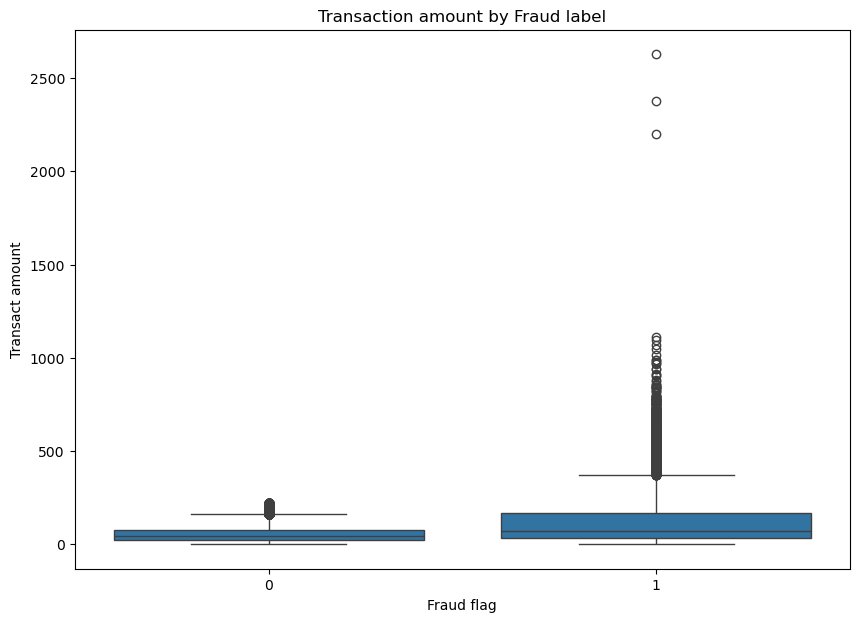

In [5]:
plt.figure(figsize = (10, 7))
sns.boxplot(data = df, x = 'TX_FRAUD', y = 'TX_AMOUNT')
plt.title('Transaction amount by Fraud label')
plt.xlabel('Fraud flag')
plt.ylabel('Transact amount')
plt.show()

we observe fraud transaction has different distribution in transaction amount: happening to large amount & more fluctuate than authentic transactions (larger std than non-fraud).  

for the purpose of unsupervised learning to clustering similarity of entity into same group, we will not remove outliner in this case (expecting the outlinier is grouping into same cluster)

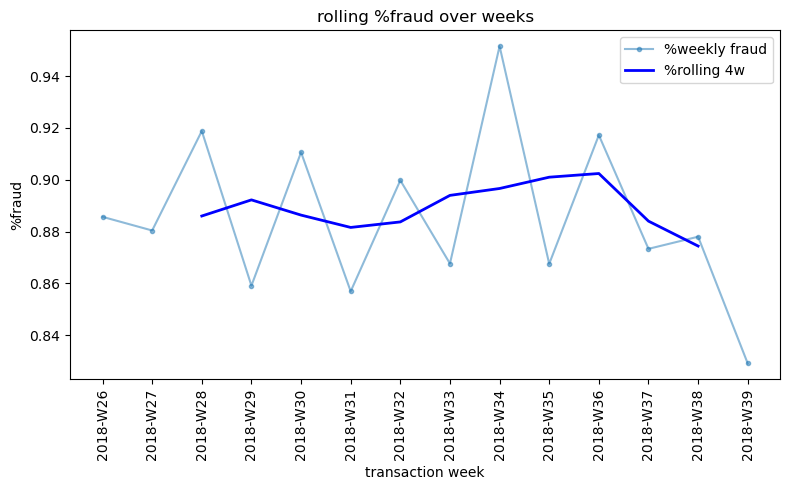

In [6]:
import matplotlib.pyplot as plt

df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])
df['YearWeek'] = df['TX_DATETIME'].dt.strftime('%Y-W%U')
fr = df.groupby('YearWeek')['TX_FRAUD'].mean() * 100

fr_sm = fr.rolling(window = 4, center = True).mean()

plt.figure(figsize = (8,5))
plt.plot(fr, marker = '.', label = '%weekly fraud', alpha = 0.5)
plt.plot(fr_sm, color = 'blue', label = '%rolling 4w', linewidth = 2)

plt.title('rolling %fraud over weeks', fontsize=12)
plt.xlabel('transaction week', fontsize=10)
plt.ylabel('%fraud', fontsize=10)
plt.xticks(rotation=90) 
plt.legend()
plt.tight_layout()
plt.show()

over 3 months from July to Sep'18, fraud rate fluctuates around 0.89% with max happening at week 34 above 0.95%.
fraud rate is low leads to imbalance data, which brings tricky issue to model evaluation, if we use accuracy score it will reach very high score, i.e fraud rate = 0.9% means if you predict all case as non-fraud giving inaccuracy rate < 0.9% and revertedly accuracy rate >= 99% but it doesn't serve the purpose of improving accuracy when predicting a case is fraud or not, avoid false alarm rate to reduce:
1) ineffective resource allocated for investigation and
2) bad user experience due to inconvenient restriction on needed actions for fraud suspection (i.e card block, direct call to user for transaction verification, ect.).

By that, we aim to increase precision:  $ \frac{true predicted fraud}{true predicted fraud + false predicted fraud}$ for efficient tool in fraud detection activity and use metric AUC_ROC score to measure distinguished power of fraud and non-fraud.



## 2. PROJECT SCOPE & METHODOLOGY

**from analysis**
we identify 4 keys group of data:
1) indexing data (transaction ID, customer_id, terminal_ID): this group of data will not contribute to model prediction
2) customer behavior (transaction amount, transaction time, transaction frequency by customer, average transaction amount within observed window, ect.)
3) terminal events (number of transaction at terminal within observed window, risk happened at terminal within observed window, ect.)
4) fraud label (fraud_label, fraud_scenario_label)


in this **scope of project**, we will focus on analyzing customer's behavior as potential features for model development, with target to predict fraud event without going to detail of potential scenario. Even though, it worths to look at distribution of fraud scenarios (~fraud type) across fraud case.

## 3. DATA EXPLORATION
1) data inspection and cleaning
2) data exploration and analysis
3) feature selection

### 3.1. First, quick clean

In [7]:
#check abnormal values, if data details is invalid, to remove
df[df['TX_AMOUNT'] == 0]['TX_AMOUNT'].count() #13 transaction has 0 amount, process similar to above
df.drop(df[df['TX_AMOUNT'] == 0].index,inplace = True)
list_amt = list(df.columns[5:]) #--exclude the ID columns
label = ['TX_FRAUD','TX_FRAUD_SCENARIO']

<Axes: xlabel='TX_FRAUD_SCENARIO'>

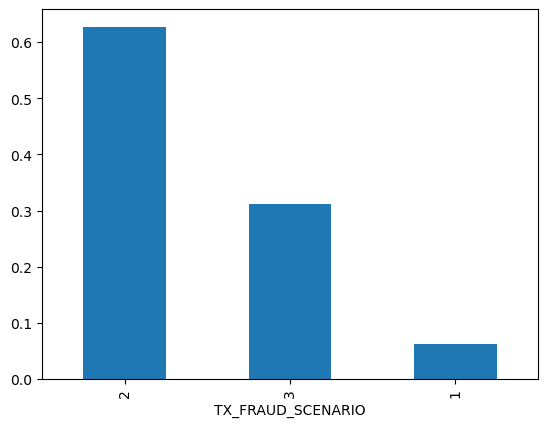

In [8]:
#statistic of fraud type:
df[df['TX_FRAUD']==1]['TX_FRAUD_SCENARIO'].value_counts(normalize = True).plot(kind = 'bar')

most of fraud happening to type 2 above 0.6, following is fraud type 3 at ~0.3 and rest on fraud type 1 at 0.06

also we observed on day-in-week (weekdays/weekends) vs. time-in-day (day/night) view, we have ~30% trnx happen in weekend, even only 2 days but customer tends to spend more during weekend.
we can see fraud on tranx during weekend is less than weekday, means we have less distinguish power on single feature of weekend. Let's look on TX_DURING_NIGHT. 
will it lead to higher fraud rate?

we have low portion of transaction at night, how is fraud rate and also how does it looks when associate weekend_night, weekday_night? 
let's have a look in heatmap

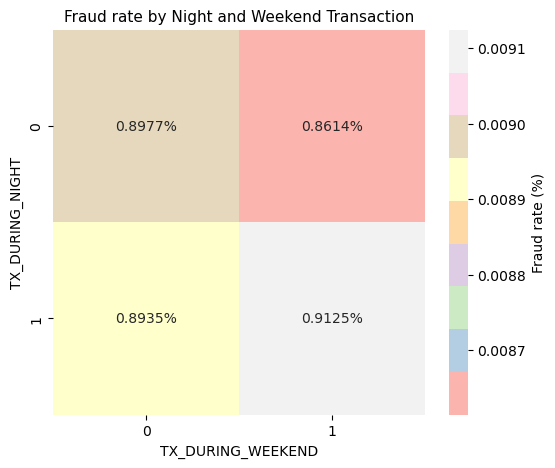

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by 'TX_DURING_NIGHT' and 'TX_DURING_WEEKEND' and calculate the mean fraud rate
grouped_data = df.groupby(['TX_DURING_NIGHT', 'TX_DURING_WEEKEND'])['TX_FRAUD'].mean().unstack()

# Plot heatmap
plt.figure(figsize = (6, 5))
sns.heatmap(grouped_data, annot=True, fmt='.4%', cmap='Pastel1', cbar_kws={'label': 'Fraud rate (%)'})

# Add labels and title
plt.title('Fraud rate by Night and Weekend Transaction', fontsize=11)
plt.xlabel('TX_DURING_WEEKEND', fontsize=10)
plt.ylabel('TX_DURING_NIGHT', fontsize=10)
plt.show()


look like fraudster has high correlation to weekend night. Let's using this information as derrive feature in model training, asending by correlation.

In [10]:
#update time dict
time_dict = {(1, 1): 4,  # Weekend Night
              (1, 0): 1,  # Weekend Day
              (0, 1): 2,  # Weekday Night
              (0, 0): 3   # Weekday Day 
            }

# Apply the mapping directly to create a new column
df['TX_period'] = df[['TX_DURING_WEEKEND', 'TX_DURING_NIGHT']].apply(tuple, axis=1).map(time_dict)


### 3.2. Second, put data into visualization for better sense

In [11]:
#let's build a plot for fraud rate observe

import matplotlib.pyplot as plt
import seaborn as sns

def plot_FR(df,feature,target = 'TX_FRAUD'):
    fr = df.groupby(feature, observed=False)[target].mean()
    
    colors = sns.color_palette('pastel', len(fr))
    ax = fr.plot(kind='bar', color = colors)

    for index, value in enumerate(fr):
        plt.text(index, value + 0.0001, f'{value*100:.2f}%', ha='center', fontsize=10)
    
    # Add titles and labels
    plt.title('%Fraud')
    plt.xlabel(feature)
    plt.ylabel(target)
    
    # Show the plot
    plt.show()

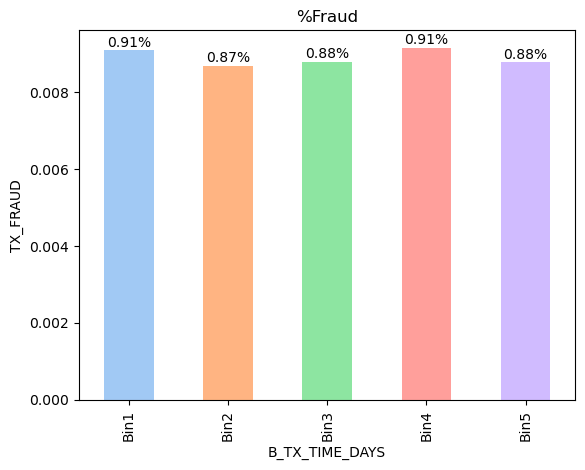

                   mean   median    std  min  max   count
B_TX_TIME_DAYS                                           
Bin1            99.9792 100.0000 5.4852   91  109  181944
Bin2           118.4941 119.0000 5.1836  110  127  172240
Bin3           136.9846 137.0000 5.4827  128  146  182018
Bin4           155.5132 156.0000 5.1942  147  164  172504
Bin5           173.4884 173.0000 5.1824  165  182  172631


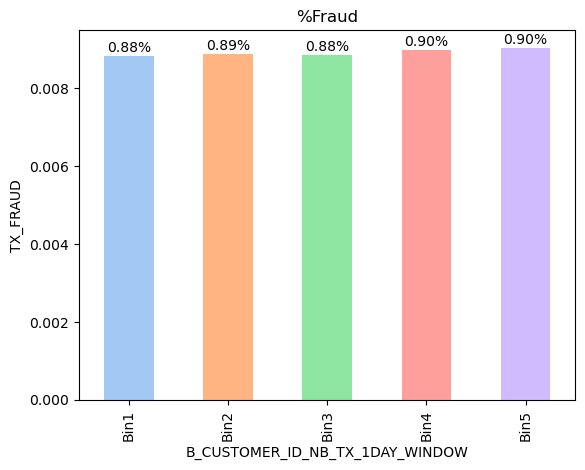

                                  mean  median    std    min     max   count
B_CUSTOMER_ID_NB_TX_1DAY_WINDOW                                             
Bin1                            1.6201  2.0000 0.4854 1.0000  2.0000  283345
Bin2                            3.0000  3.0000 0.0000 3.0000  3.0000  191052
Bin3                            4.0000  4.0000 0.0000 4.0000  4.0000  161911
Bin4                            5.0000  5.0000 0.0000 5.0000  5.0000  113533
Bin5                            6.8148  6.0000 1.0870 6.0000 16.0000  131496


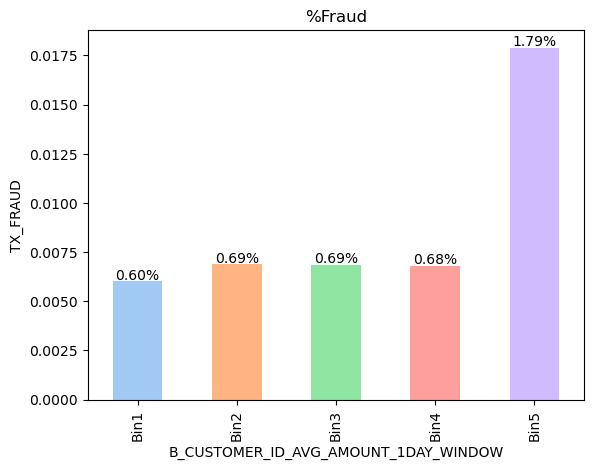

                                         mean  median     std     min       max   count
B_CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW                                                   
Bin1                                  12.3810 12.3150  4.9717  0.0100   21.0400  176270
Bin2                                  30.3774 30.4100  5.3874 21.0400   39.6750  176266
Bin3                                  49.3200 49.2350  5.6559 39.6750   59.3080  176266
Bin4                                  70.3312 70.0640  6.6323 59.3080   82.4200  176267
Bin5                                 105.7560 99.2540 28.4790 82.4200 1377.0750  176268


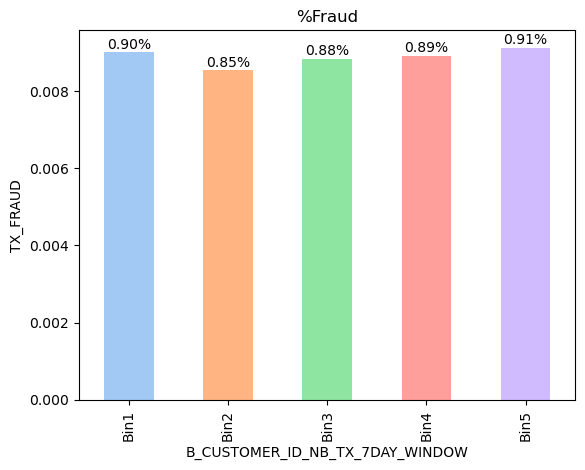

                                   mean  median    std     min     max   count
B_CUSTOMER_ID_NB_TX_7DAY_WINDOW                                               
Bin1                             8.3168  9.0000 2.9112  1.0000 12.0000  192920
Bin2                            15.1155 15.0000 1.4068 13.0000 17.0000  176872
Bin3                            19.5212 20.0000 1.1158 18.0000 21.0000  169061
Bin4                            23.8717 24.0000 1.4029 22.0000 26.0000  189907
Bin5                            30.2900 30.0000 3.0976 27.0000 51.0000  152577


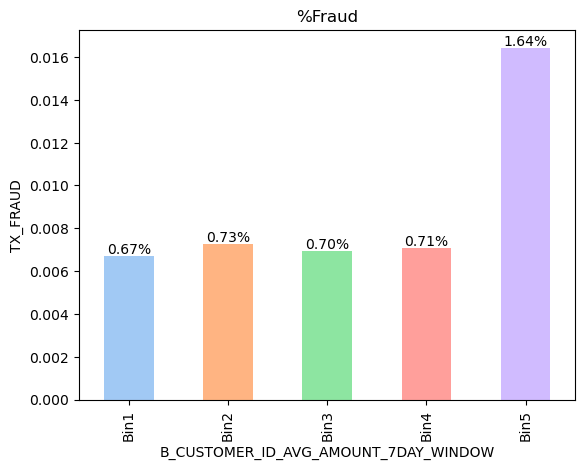

                                        mean  median     std     min      max   count
B_CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW                                                 
Bin1                                 13.6918 13.7486  5.2091  0.0700  22.9138  176268
Bin2                                 33.0943 33.2759  5.6557 22.9140  42.7369  176267
Bin3                                 52.3908 52.3779  5.6045 42.7370  62.2124  176267
Bin4                                 72.0604 72.0750  5.5979 62.2124  81.8344  176267
Bin5                                 96.8227 93.3415 17.1307 81.8345 509.2833  176268


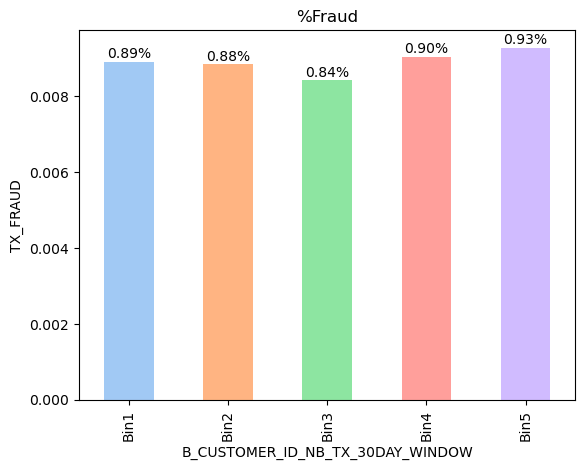

                                     mean   median     std      min      max   count
B_CUSTOMER_ID_NB_TX_30DAY_WINDOW                                                    
Bin1                              34.3933  36.0000 11.9996   1.0000  51.0000  180647
Bin2                              62.9837  63.0000  6.3200  52.0000  73.0000  177866
Bin3                              82.4266  83.0000  4.9293  74.0000  90.0000  176499
Bin4                              97.9195  98.0000  4.2811  91.0000 105.0000  180778
Bin5                             115.4286 114.0000  7.6492 106.0000 157.0000  165547


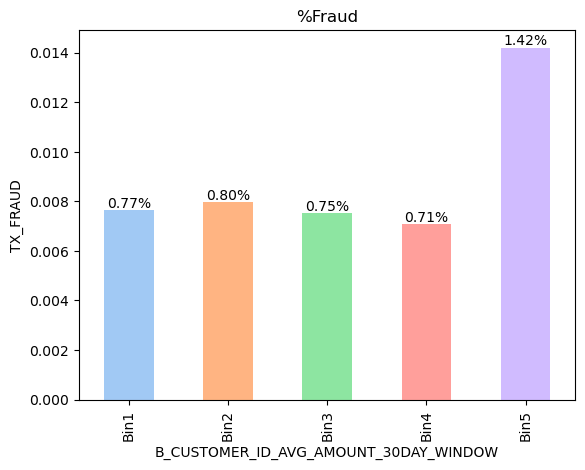

                                         mean  median     std     min      max   count
B_CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW                                                 
Bin1                                  13.9091 14.0642  5.2615  0.3900  23.2471  176268
Bin2                                  33.5739 33.6966  5.7172 23.2474  43.5233  176267
Bin3                                  53.1127 53.1485  5.6143 43.5236  62.9552  176267
Bin4                                  72.8628 72.9696  5.4990 62.9552  82.3192  176267
Bin5                                  94.7154 92.9254 10.9138 82.3194 291.0900  176268


In [12]:
#let's see distribution of fraud rate on bins, also statistic to understand distribution of data within the bin

bin_data = ['TX_TIME_DAYS', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW',
           'CUSTOMER_ID_NB_TX_30DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW']

for b in bin_data:
    label = f'B_{b}'
    df[label] = pd.qcut(df[b], q = 5, labels=['Bin1', 'Bin2', 'Bin3', 'Bin4', 'Bin5'], duplicates = 'drop')
    plot_FR(df,label)
    print(df.groupby(label, observed = False)[b].agg(['mean', 'median', 'std', 'min', 'max', 'count']))


we observe features relates to transaction amount is a potential indicator for fraud detection, as observing the higher of amount spending, the more increasing in fraud rate.

### 3.3. Feature selection

In [13]:
# now we select this set of features and define label to observe correlation via heatmap below:
features = ['TX_AMOUNT',
            'TX_TIME_SECONDS',
            'TX_TIME_DAYS',
            'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
            'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW',
            'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
            'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW',
            'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
            'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW',
            'TX_period']

label = 'TX_FRAUD'

def plot_correlation_heatmap(df, features, label):
    df_subset = df[features + [label]]
    correlation_matrix = df_subset.corr()
    correl = df_subset.corr()[label].abs().sort_values(ascending=False)

    # plotting
    plt.figure(figsize=(10, 8)) 
    sns.heatmap(correlation_matrix, annot = True, cmap = 'Pastel1', fmt = '.2f', linewidths = 0.5)
    plt.title('Correlation Heatmap')
    plt.show()

    return correl

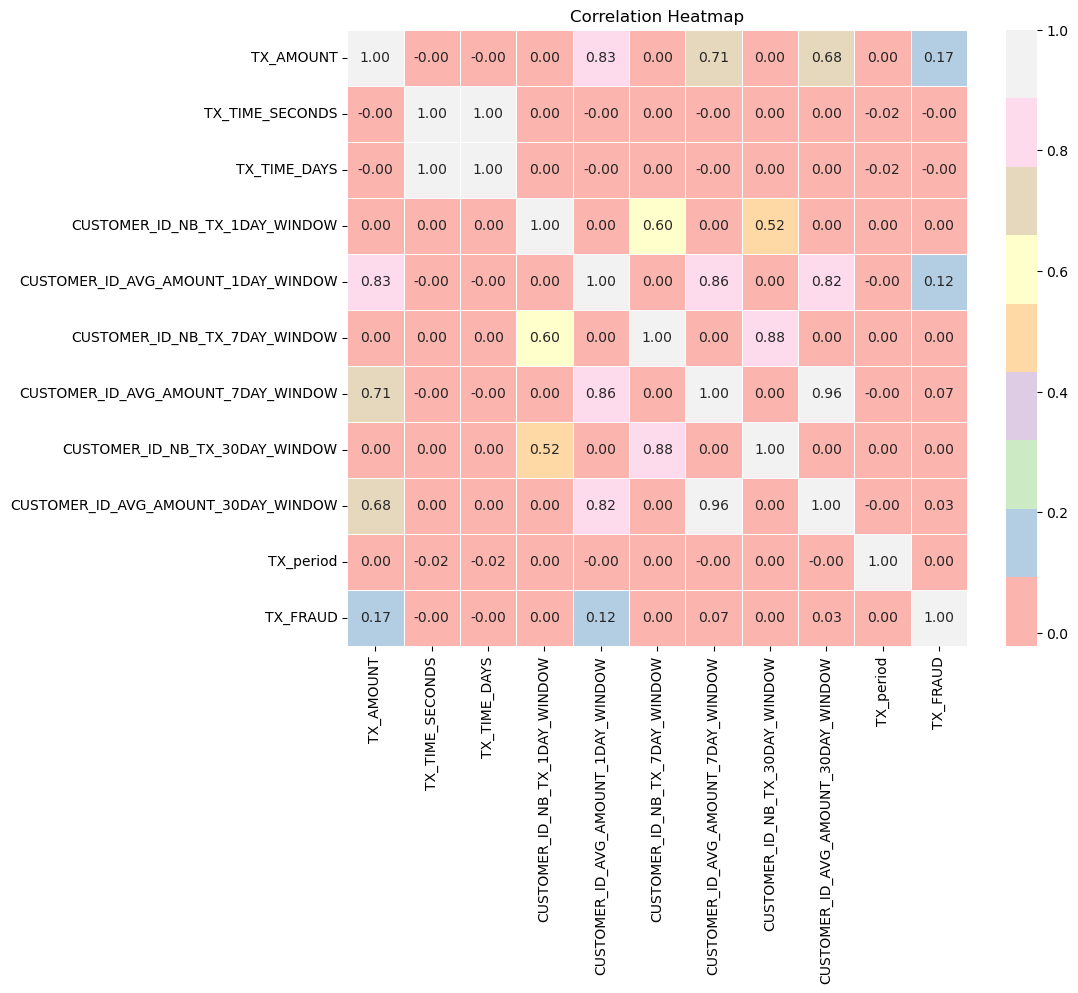

TX_FRAUD                              1.0000
TX_AMOUNT                             0.1674
CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW    0.1190
CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW    0.0692
CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW   0.0283
TX_period                             0.0016
CUSTOMER_ID_NB_TX_30DAY_WINDOW        0.0015
CUSTOMER_ID_NB_TX_7DAY_WINDOW         0.0012
CUSTOMER_ID_NB_TX_1DAY_WINDOW         0.0007
TX_TIME_DAYS                          0.0000
TX_TIME_SECONDS                       0.0000
Name: TX_FRAUD, dtype: float64

In [14]:
plot_correlation_heatmap(df, features,label)

In [15]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


features on average amount and number of transaction amongst observed window may appear to have multicollienary, thus let's check it out:

In [16]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

vif_data = pd.DataFrame()
vif_data['Feature'] = features
vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
vif_data

,Feature,VIF
0,TX_AMOUNT,3.1385
1,TX_TIME_SECONDS,15939.7265
2,TX_TIME_DAYS,15939.4590
3,CUSTOMER_ID_NB_TX_1DAY_WINDOW,1.5548
4,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,6.0923
5,CUSTOMER_ID_NB_TX_7DAY_WINDOW,4.8983
6,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,14.7679
7,CUSTOMER_ID_NB_TX_30DAY_WINDOW,4.3380
8,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,11.6397
9,TX_period,1.0029


as we find there are high multicolinearity in some features above (where VIF is above 10) thus only selected feature will be processed to model developemnt.

In [17]:
strong_f = vif_data[vif_data['VIF'] <= 10]['Feature'].tolist()
strong_f

['TX_AMOUNT',
 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
 'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW',
 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
 'TX_period']

**We will select strong feature on those have correlation to fraud case (corr >= 0.1%). On the other hand, average amount in window 7 days, 30 days has strong correlation to TX_AMOUNT, thus to avoid collinearity issue we will select only 'TX_AMOUNT' and 'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW'.
Regarding information from datetime, we don't see much correlation on TX_Time_days and TX_Time_seconds but there is potential on TX_period --> select this feature.
regarding 'CUSTOMER_ID_NB_TX_30DAY_WINDOW' presenting number of transaction that customer made in observed window, we found weak correlation to fraud rate, thus we will remove this view from model development.**

## 4. MODEL DEVELOPMENT

In the context of credit card fraud detection, DBSCAN can identify:
Clusters of Normal Transactions: Typical customer behavior forms dense clusters.
Outliers as Anomalies: Fraudulent transactions often appear as noise or fall into small, sparse clusters due to their atypical nature (e.g., unusual transaction amounts or locations).
For example, suppose most transactions cluster tightly around low amounts and local merchants. In that case, a high-value transaction in a distant location may be flagged as suspicious by DBSCAN.

Limitations
Parameter Sensitivity: The performance heavily depends on setting appropriate eps (radius) and min_samples. If chosen poorly, DBSCAN may fail to find meaningful clusters.
Varied Densities: Struggles with clusters of different densities since it uses a single eps for all regions.
High Dimensionality: Efficiency and effectiveness drop when working with high-dimensional data due to the "curse of dimensionality."

Strengths of DBSCAN
No Predefined Cluster Count: Unlike K-means, you don't need to specify the number of clusters in advance.
Handles Noise: DBSCAN identifies and labels outliers as noise, making it suitable for real-world datasets with anomalies.
Flexible Cluster Shapes: It can detect clusters of arbitrary shapes (e.g., circular or elongated), unlike K-means, which assumes spherical clusters.
Scalable: Works well for large datasets if implemented efficiently.

purpose of this project is to compare the best tool between DBSCAN and K-Means in 
1) ability to group similar entity into same group by considering sihouette score, so called performance
2) efficiency of model considering in resource taken to train on same size, so called efficient.

In [18]:
df_train = df.loc[:, strong_f] #only use feature selected before to strong_f
df_train['TX_FRAUD'] = df['TX_FRAUD'] #adding fraud label 

**now we start to apply unsupervised algo to clean data. We will learn efficiency of each method in this scope of project:**
1) **DBSCAN**
2) **K-Means**

### 4.1. Instantiate model for unsupervised learning with DBSCAN

we will train unsupervised model begining with DBSCAN. Before determine on which params we should select for optimized model, we will looping through different values and evaluate base on Noise ratio and/or training duration to pick the best params:

In [ ]:
import time
import psutil
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


#instantiate dict for tracking performance:
DBSCAN_tracker = {}

#set threshold for memory usage
total_memory = psutil.virtual_memory().total
memory_threshold = total_memory * 0.6
print(f'Memory Threshold: {memory_threshold / (1024 ** 3):.2f} GB')

eps_val = [0.5, 1.0, 1.5] 
min_sample_val = [5, 8, 12]

#start looping through different sample size
for f in [0.05, 0.1, 0.2, 0.3, 0.5, 1.0]: 
    sampled_data = df_train.sample(frac = f, random_state = 42)
    scaled_sampled_data = scaler.fit_transform(sampled_data[strong_f])
    for e in eps_val:
        for ms in min_sample_val:
            start_time = time.time()
            dbscan = DBSCAN(eps = e, min_samples = ms)
            dbscan_labels = dbscan.fit_predict(scaled_sampled_data)
            end_time = time.time()
            
            DBSCAN_tracker[(f, e, ms)] = {'Train duration': end_time - start_time, 'Noise ratio': (dbscan_labels == -1).sum() / len(dbscan_labels)}
            print(f'Fraction: {f*100:.0f}%, eps: {e}, min_sample: {ms}, Train duration: {end_time - start_time:.4f} sec, Noise ratio: {DBSCAN_tracker[(f, e, ms)]['Noise ratio']:.2%}')

Memory Threshold: 4.80 GB
Fraction: 5%, eps: 0.5, min_sample: 5, Train duration: 0.8640 sec, Noise ratio: 8.70%
Fraction: 5%, eps: 0.5, min_sample: 8, Train duration: 0.8505 sec, Noise ratio: 12.93%
Fraction: 5%, eps: 0.5, min_sample: 12, Train duration: 0.8474 sec, Noise ratio: 18.22%
Fraction: 5%, eps: 1.0, min_sample: 5, Train duration: 3.1645 sec, Noise ratio: 0.47%
Fraction: 5%, eps: 1.0, min_sample: 8, Train duration: 3.1685 sec, Noise ratio: 0.54%
Fraction: 5%, eps: 1.0, min_sample: 12, Train duration: 3.2079 sec, Noise ratio: 0.63%
Fraction: 5%, eps: 1.5, min_sample: 5, Train duration: 8.0686 sec, Noise ratio: 0.20%
Fraction: 5%, eps: 1.5, min_sample: 8, Train duration: 8.1322 sec, Noise ratio: 0.22%
Fraction: 5%, eps: 1.5, min_sample: 12, Train duration: 8.3242 sec, Noise ratio: 0.22%
Fraction: 10%, eps: 0.5, min_sample: 5, Train duration: 2.6026 sec, Noise ratio: 4.82%
Fraction: 10%, eps: 0.5, min_sample: 8, Train duration: 2.6126 sec, Noise ratio: 7.02%
Fraction: 10%, eps: 0

#### use determine value to define selected model:

Smaller eps (e.g., 0.5) tends to have higher noise ratios but much faster training times.
Larger eps (e.g., 1.0, 1.5) significantly reduces noise but increases training time.
Increasing min_samples generally increases noise ratios slightly, as more points are considered noise.

In [20]:
#set of param across algo selected from above iteration to test effectiveness across algo
frac = 0.2
eps = 1.5
min_samples = 5

#set selected fraction after evaluation above:
sampled_data = df_train.sample(frac = frac, random_state = 42)

# scaled data from fraction sample
scaled_sampled_data = scaler.fit_transform(sampled_data[strong_f])

#set eps and min_samples after above iteration
dbscan = DBSCAN(eps = eps, min_samples = min_samples)
dbscan_labels = dbscan.fit_predict(scaled_sampled_data) #fit to scaled_data with same sample ratio of DBSCAN and predict cluster
#update cluster label by DBSCAN
sampled_data['DBSCAN_Cluster'] = dbscan_labels

#verify number of clusters created:
sampled_data['DBSCAN_Cluster'].value_counts()

DBSCAN_Cluster
 0    176044
-1       183
 1        12
 2         8
 3         6
 4         5
 6         5
 5         4
Name: count, dtype: int64

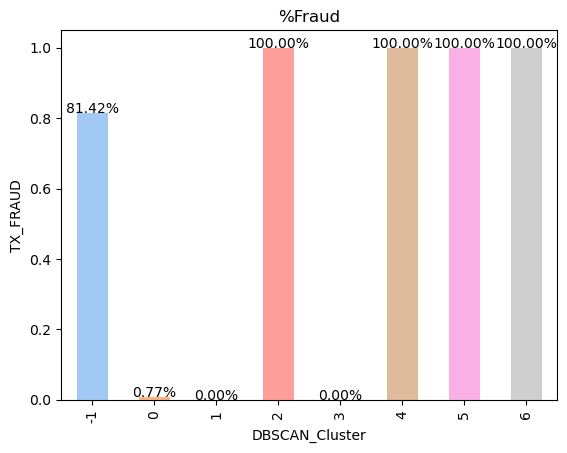

In [21]:
plot_FR(sampled_data, 'DBSCAN_Cluster')

in general, DBSCAN algorithm can identified clusters with varying characters for fraudulent transactions. Cluster -1 stands out as a good indicator of fraud as high associated with fraud rate on 100+ observation. On the other hand, except cluster 0, the other clusters more likely indicate outliner transaction as observed on small number (below 10 obs).

### 4.2. Instantiate model for unsupervised learning with K-Means 

by K-means, we will select best number of cluster for model via Inertia value. 
The point is to compare efficiency between 2 models, same training sample size, which one is better?

In [22]:
import time
import psutil
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

#instantiate K-means tracker
KMeans_tracker = {}

total_memory = psutil.virtual_memory().total
memory_threshold = total_memory * 0.6 
print(f'Memory Threshold: {memory_threshold / (1024 ** 3):.2f} GB')

n_val = [2, 3, 5, 8, 10]  

for f in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]: 
    try:
        sampled_data_KM = df_train.sample(frac = f, random_state = 42)
        scaled_sampled_data = scaler.fit_transform(sampled_data_KM[strong_f])
        memory_usage = psutil.virtual_memory().used
        
        if memory_usage >= memory_threshold:
            break

        for n in n_val:
            start_time = time.time()
            kmeans = KMeans(n_clusters = n, random_state = 42)
            kmeans_labels = kmeans.fit_predict(scaled_sampled_data)
            end_time = time.time()
            KMeans_tracker[(f, n)] = {'Training Time': end_time - start_time, 'Inertia': kmeans.inertia_, 'Cluster Count': len(set(kmeans_labels))}
            print(f'Fraction: {f*100:.0f}%, n_clusters: {n}, '
                  f'Training Time: {end_time - start_time:.4f} seconds, '
                  f'Inertia: {KMeans_tracker[(f, n)]['Inertia']:.4f}' ) 

    except Exception as e:
        print(f'Error at size {f*100:.0f}%: {str(e)}')
        break


Memory Threshold: 4.80 GB
Fraction: 5%, n_clusters: 2, Training Time: 0.1520 seconds, Inertia: 194447.6291
Fraction: 5%, n_clusters: 3, Training Time: 0.0180 seconds, Inertia: 170668.4995
Fraction: 5%, n_clusters: 5, Training Time: 0.0194 seconds, Inertia: 125392.9302
Fraction: 5%, n_clusters: 8, Training Time: 0.0235 seconds, Inertia: 100015.6727
Fraction: 5%, n_clusters: 10, Training Time: 0.0458 seconds, Inertia: 90051.1033
Fraction: 10%, n_clusters: 2, Training Time: 0.0168 seconds, Inertia: 388893.1925
Fraction: 10%, n_clusters: 3, Training Time: 0.0171 seconds, Inertia: 317914.7597
Fraction: 10%, n_clusters: 5, Training Time: 0.0480 seconds, Inertia: 251281.3031
Fraction: 10%, n_clusters: 8, Training Time: 0.0508 seconds, Inertia: 199530.0692
Fraction: 10%, n_clusters: 10, Training Time: 0.0493 seconds, Inertia: 182410.8104
Fraction: 20%, n_clusters: 2, Training Time: 0.0303 seconds, Inertia: 778145.3316
Fraction: 20%, n_clusters: 3, Training Time: 0.0396 seconds, Inertia: 638294

we found training time wouldn't be a problem to K-Means. Thus let's assessing if same fraction how well each algo can select cluster.
Base on performance above we would select n = 8 considering where Inertia start to drop less

In [23]:
#we use same sample size to be comparable on performance and efficiency with DBSCAN clustering
scaled_sampled_data = scaler.fit_transform(sampled_data[strong_f]) #scaling

#from above iteration/tuning params for sample size at 20% of origin dataset, base on inertia we select n = 8 as observe no rapid drop on later n.
kmeans = KMeans(n_clusters = 8, random_state = 42)
kmeans_labels = kmeans.fit_predict(scaled_sampled_data) #fit to scaled_data with same sample ratio of DBSCAN and predict cluster

#update cluster label
sampled_data['KMean_Cluster'] = kmeans_labels

#verify number of clusters created:
sampled_data['KMean_Cluster'].value_counts(normalize = True)

KMean_Cluster
1   0.1767
7   0.1494
3   0.1428
2   0.1314
5   0.1227
6   0.1101
4   0.0843
0   0.0825
Name: proportion, dtype: float64

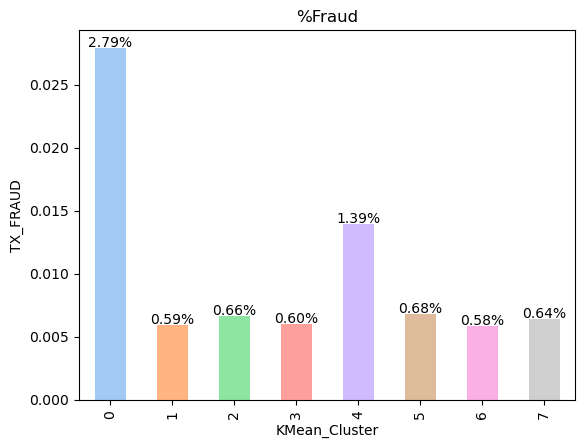

In [24]:
#cluster association with fraud rate:
plot_FR(sampled_data, 'KMean_Cluster')

### 4.3. Unsupervised model evaluation

as we see param's values selection method/criteria for DBSCAN and Kmeans are using 2 different metrics (noise rate vs. inertia), thus to compare efficiency of these 2 algo, we use silhouette_score as same metric to evaluate, in which it reflect how much of entity's similarity within a cluster, the higher the better (means entity in same cluster expecting to share closest characters than comparing between that entity with other cluster). Now let's compare between DBSCAN and K-Means

In [25]:
# Then compute Silhouette Score
from sklearn.metrics import silhouette_score
metric_dict = {}

S_score_DBSCAN = silhouette_score(sampled_data[strong_f], dbscan_labels) #DBSCAN label was created by above model
metric_dict['Silhouette Score DBScan'] = S_score_DBSCAN

S_score_KMeans = silhouette_score(sampled_data[strong_f], kmeans_labels) #K-means label was created by above model
metric_dict['Silhouette Score KMeans'] = S_score_KMeans

#now we compare silhouette score between 2 methods:
metric_dict

{'Silhouette Score DBScan': 0.6504054703853585,
 'Silhouette Score KMeans': 0.048762360926427106}

**conclusion on unsupervised model for clustering**

Base on Silhouette score we see DBSCAN work much better in clustering task, however comparing to K_means method, it requires much more time and resource to handling same set of data as we found in tuning/params iteration proccess above.


and to DBSCAN, number of cluster forming will depend on how much tolerate we accept on the entity classified in low-relative cluster, which is eps value. The larger of eps, the less number of cluster forming (because we accept more of less-alike entity within same cluster)

For K-Means, we want to explore a bit further, to understand if we input more sample into training, will the cluster still work this good? 
Thus, to fit in practical situation, where we need efficient tool for clustering purpose, we will develop onwards on K-means.
In business situation, there will be required balance between cost (more investment) and profit (more effective). Thus we will seek a step further to apply these cluster label as new feature for supervised training to observe also predictive potential for a fraud event.

### 4.4. Hybrid model Unsupervised || Supervised Learning

In [26]:
# dataset NOT using K_Means or DBSCAN as one of new feature --to compare the performance stand-alone vs. merging unsupervised cluster
X = sampled_data.drop(columns = ['TX_FRAUD', 'DBSCAN_Cluster','KMean_Cluster']).copy()
y = sampled_data['TX_FRAUD'].copy()

In [27]:
# dataset using DBSCAN as one of new feature
X_DB = sampled_data.drop(columns = ['TX_FRAUD', 'KMean_Cluster']).copy()
y_DB = sampled_data['TX_FRAUD'].copy()

In [28]:
#  dataset using K_Means as one of new feature
X_KM = sampled_data.drop(columns = ['TX_FRAUD', 'DBSCAN_Cluster']).copy()
y_KM = sampled_data['TX_FRAUD'].copy()

Results for RF without cluster:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     52441
           1       1.00      0.20      0.33       440

    accuracy                           0.99     52881
   macro avg       1.00      0.60      0.66     52881
weighted avg       0.99      0.99      0.99     52881

confusion_matrix: [[52441     0]
 [  353    87]]
ROC AUC Score: 0.6411894709379026
Gini: 0.28237894187580515
Precision (Fraud Label): 1.0


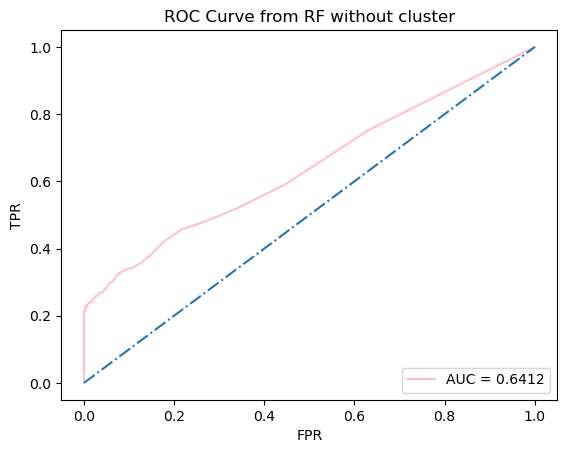

Results for RF with DBSCAN cluster:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     52441
           1       1.00      0.20      0.33       440

    accuracy                           0.99     52881
   macro avg       1.00      0.60      0.66     52881
weighted avg       0.99      0.99      0.99     52881

confusion_matrix: [[52441     0]
 [  353    87]]
ROC AUC Score: 0.6223729567947355
Gini: 0.24474591358947095
Precision (Fraud Label): 1.0


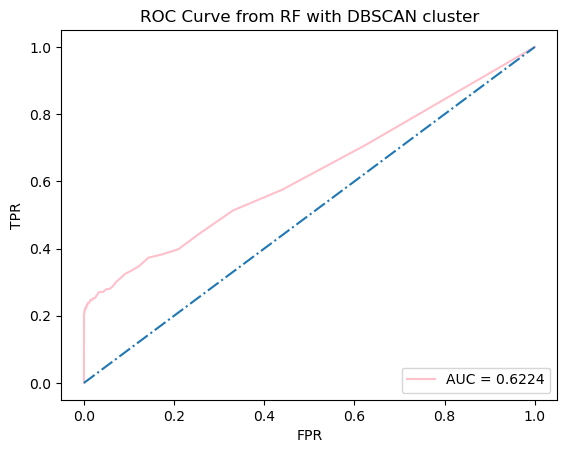

Results for RF with K-Means cluster:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     52441
           1       1.00      0.20      0.33       440

    accuracy                           0.99     52881
   macro avg       1.00      0.60      0.66     52881
weighted avg       0.99      0.99      0.99     52881

confusion_matrix: [[52441     0]
 [  353    87]]
ROC AUC Score: 0.6286394796923296
Gini: 0.25727895938465917
Precision (Fraud Label): 1.0


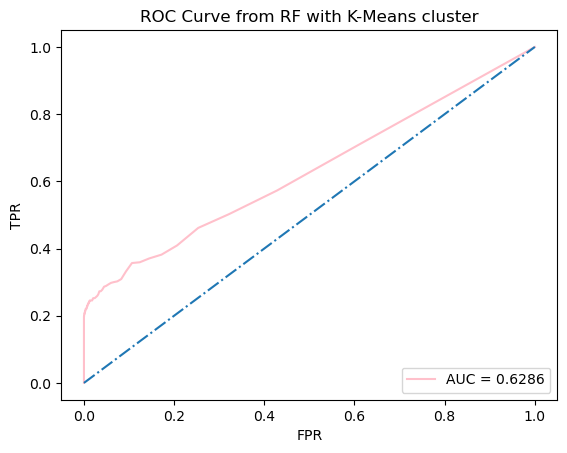

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

def RF_pipeline(X, y, dt):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    
    #instantiate Random Forest Classifier
    rf_model = RandomForestClassifier(random_state = 42, n_estimators = 500) 
    rf_model.fit(X_train, y_train)
    
    #predict 
    y_pred = rf_model.predict(X_test)

    #evaluate
    print(f'Results for {dt}:\n')
    print(classification_report(y_test, y_pred))
    print(f'confusion_matrix: {confusion_matrix(y_test, y_pred)}')
    
    #calculate Gini
    y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_prob)
    print('ROC AUC Score:', auc_score)
    print(f'Gini: {auc_score * 2 - 1}')
    
    #as we want to improve the detection tool, thus we expect prediction a transaction to be fraud (positive) have high accuracy, thus we focus on fraud precision score
    precision_fraud = precision_score(y_test, y_pred, pos_label=1)
    print('Precision (Fraud Label):', precision_fraud)
    
    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, color = 'pink', label = f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], linestyle = '-.') 
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'ROC Curve from {dt}')
    plt.legend(loc='lower right')
    plt.show()
    
    return {'confusion_matrix': confusion_matrix(y_test, y_pred),
            'ROC_AUC': auc_score,
            'Precision_Fraud': precision_fraud }

#now we use this pipeline across dataset to compare performance of superivsed model Random Forest when NOT having any support from unsupervised model, vs. having support from DBSCAN, vs. having support from K-Means.
RF_X = RF_pipeline(X, y, dt = 'RF without cluster')
RF_DB = RF_pipeline(X_DB, y_DB, dt = 'RF with DBSCAN cluster')
RF_KM = RF_pipeline(X_KM, y_KM, dt = 'RF with K-Means cluster')


in Random Forest, we see Gini is highest on non-cluster, then perform better on DBSCAN cluster comparing to K-Means cluster. Ranking is:
1. origin
2. DBSCAN
3. K-Means


Results for LR without cluster:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     52441
           1       1.00      0.08      0.15       440

    accuracy                           0.99     52881
   macro avg       1.00      0.54      0.57     52881
weighted avg       0.99      0.99      0.99     52881

confusion_matrix: [[52441     0]
 [  405    35]]
ROC AUC Score: 0.6527806140580497
Gini: 0.3055612281160993
Precision (Fraud Label): 1.0


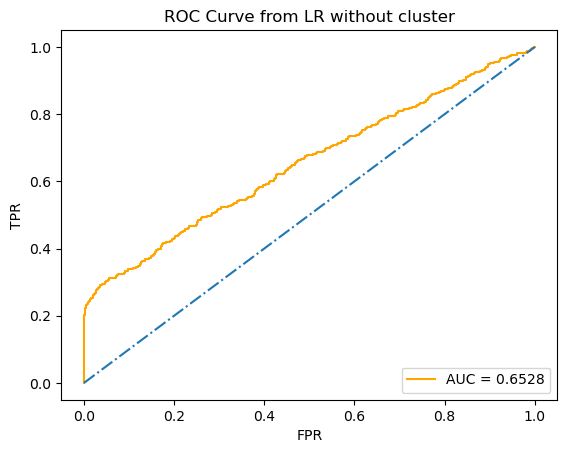

Results for LR with DBSCAN cluster:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     52441
           1       1.00      0.08      0.14       440

    accuracy                           0.99     52881
   macro avg       1.00      0.54      0.57     52881
weighted avg       0.99      0.99      0.99     52881

confusion_matrix: [[52441     0]
 [  406    34]]
ROC AUC Score: 0.6532286500326774
Gini: 0.30645730006535477
Precision (Fraud Label): 1.0


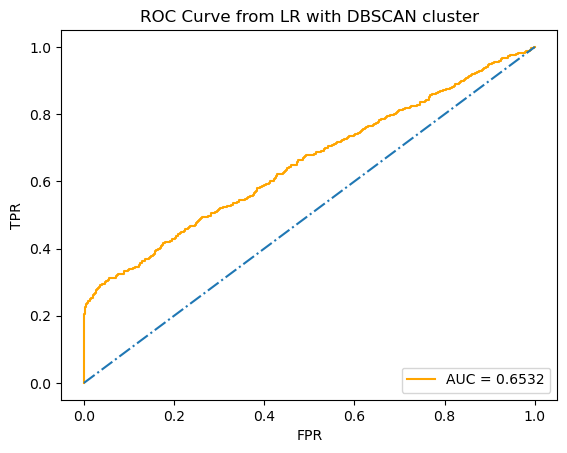

Results for LR with K-Means cluster:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     52441
           1       1.00      0.08      0.15       440

    accuracy                           0.99     52881
   macro avg       1.00      0.54      0.57     52881
weighted avg       0.99      0.99      0.99     52881

confusion_matrix: [[52441     0]
 [  405    35]]
ROC AUC Score: 0.6525500952585677
Gini: 0.30510019051713533
Precision (Fraud Label): 1.0


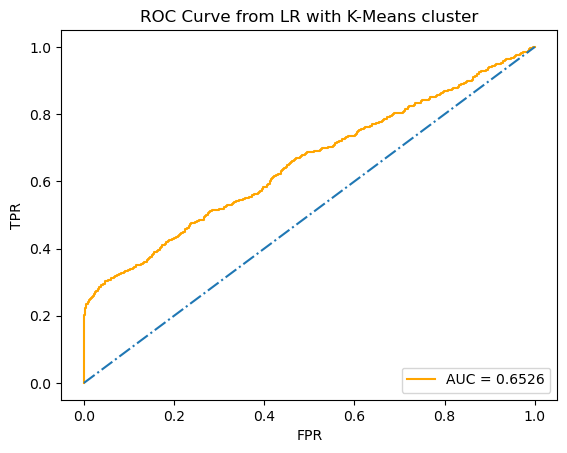

In [48]:
from sklearn.linear_model import LogisticRegression

def LR_pipeline(X, y, dt):
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    
    #Instantiate Logistic Regression
    log_reg = LogisticRegression(random_state = 42, max_iter = 500)
    log_reg.fit(X_train, y_train)
    
    #predict
    y_pred = log_reg.predict(X_test)
    
    print(f'Results for {dt}:\n')
    print(classification_report(y_test, y_pred))
    print(f'confusion_matrix: {confusion_matrix(y_test, y_pred)}')
    
    #evaluate by AUC/Gini
    y_pred_prob = log_reg.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_prob)
    
    print('ROC AUC Score:', auc_score)
    print(f'Gini: {auc_score * 2 - 1}')
    
    #as we want to improve the detection tool, thus we expect prediction a transaction to be fraud (positive) have high accuracy, thus we focus on fraud precision score
    precision_fraud = precision_score(y_test, y_pred, pos_label=1)
    print('Precision (Fraud Label):', precision_fraud)
    
    #Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, color = 'orange', label = f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1],  linestyle = '-.')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'ROC Curve from {dt}')
    plt.legend(loc = 'lower right')
    plt.show()

    return {'confusion_matrix': confusion_matrix(y_test, y_pred),
            'ROC_AUC': auc_score,
            'Precision_Fraud': precision_fraud}

#now we use this pipeline across dataset to compare performance of superivsed model Logistic Regression algo when NOT having any support from unsupervised model, vs. having support from DBSCAN, vs. having support from K-Means.
LR_X = LR_pipeline(X, y, dt = 'LR without cluster')
LR_DB = LR_pipeline(X_DB, y_DB, dt = 'LR with DBSCAN cluster')
LR_KM = LR_pipeline(X_KM, y_KM, dt = 'LR with K-Means cluster')


Results for XGB without cluster:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     52441
           1       0.66      0.15      0.24       440

    accuracy                           0.99     52881
   macro avg       0.83      0.57      0.62     52881
weighted avg       0.99      0.99      0.99     52881

confusion_matrix: [[52407    34]
 [  374    66]]
ROC AUC Score: 0.623972026571853
Gini: 0.24794405314370604
Precision (Fraud Label): 0.66


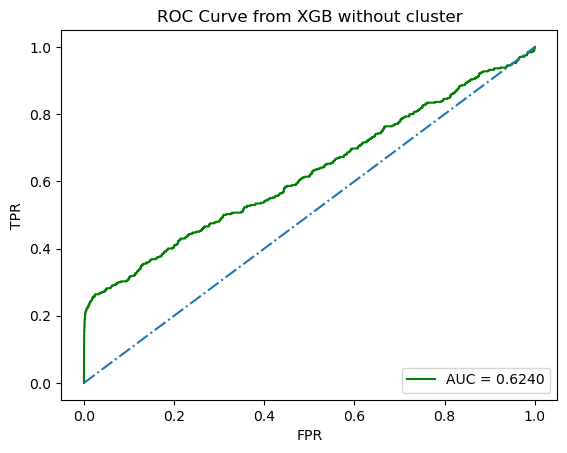

Results for XGB with DBSCAN cluster:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     52441
           1       0.75      0.16      0.27       440

    accuracy                           0.99     52881
   macro avg       0.87      0.58      0.63     52881
weighted avg       0.99      0.99      0.99     52881

confusion_matrix: [[52417    24]
 [  368    72]]
ROC AUC Score: 0.6376370371205042
Gini: 0.27527407424100847
Precision (Fraud Label): 0.75


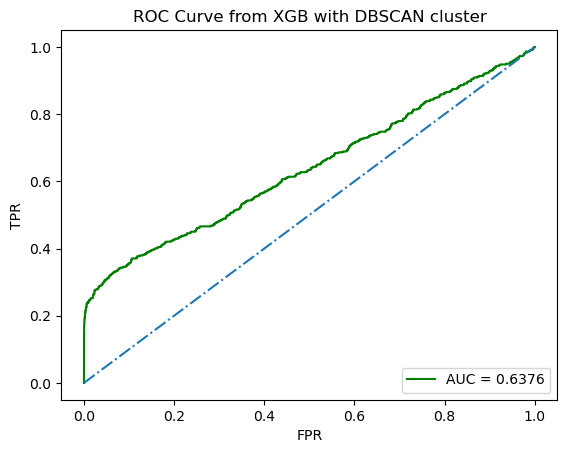

Results for XGB with K-Means cluster:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     52441
           1       0.61      0.14      0.23       440

    accuracy                           0.99     52881
   macro avg       0.80      0.57      0.61     52881
weighted avg       0.99      0.99      0.99     52881

confusion_matrix: [[52400    41]
 [  377    63]]
ROC AUC Score: 0.6377934033225218
Gini: 0.27558680664504354
Precision (Fraud Label): 0.6057692307692307


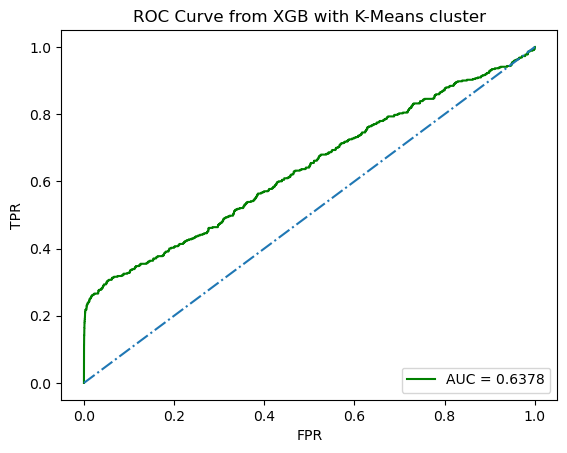

In [49]:
from xgboost import XGBClassifier

def xgb_pipeline(X, y, dt):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    
    #Instantiate Xgboost
    xgb_model = XGBClassifier(random_state = 42, eval_metric = 'auc')
    xgb_model.fit(X_train, y_train)
    
    #predict
    y_pred = xgb_model.predict(X_test)
    print(f'Results for {dt}:\n')
    print(classification_report(y_test, y_pred))
    print(f'confusion_matrix: {confusion_matrix(y_test, y_pred)}')
    
    #calculate Gini
    y_pred_prob = xgb_model.predict_proba(X_test)[:, 1] 
    auc_score = roc_auc_score(y_test, y_pred_prob)
    print(f'ROC AUC Score: {auc_score}')
    print(f'Gini: {auc_score * 2 - 1}')
    
   #calculate fraud precision score
    precision_fraud = precision_score(y_test, y_pred, pos_label=1)
    print(f'Precision (Fraud Label): {precision_fraud}')
    
    #plot roc curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, color = 'green', label = f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], linestyle = '-.')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'ROC Curve from {dt}')
    plt.legend(loc='lower right')
    plt.show()
    
    return {'confusion_matrix': confusion_matrix(y_test, y_pred),
            'ROC_AUC': auc_score,
            'Precision_Fraud': precision_fraud}

#now we use this pipeline across dataset to compare performance of superivsed model XGBoost Classifier when NOT having any support from unsupervised model, vs. having support from DBSCAN, vs. having support from K-Means.
XGB_X = xgb_pipeline(X, y, dt = 'XGB without cluster')
XGB_DB = xgb_pipeline(X_DB, y_DB, dt = 'XGB with DBSCAN cluster')
XGB_KM = xgb_pipeline(X_KM, y_KM, dt = 'XGB with K-Means cluster')


as we see performance of xgb is low, let's see on tuning params if help performing better

In [50]:
from sklearn.model_selection import GridSearchCV

def tuning_xgb(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    
    param_grid = {'n_estimators': [100, 200, 500],
                  'max_depth': [3, 5, 7],
                  'learning_rate': [0.01, 0.1, 0.2],
                  'subsample': [0.6, 0.8, 1.0],
                  'colsample_bytree': [0.6, 0.8, 1.0],
                  'gamma': [0, 0.1, 0.5]}
    
    xgb = XGBClassifier(random_state = 42, eval_metric = 'auc')
    
    grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring = 'roc_auc', cv = 3, verbose = 1, n_jobs = -1)
    grid_search.fit(X_train, y_train)
    
    print(f'Best params: {grid_search.best_params_}')
    print(f'Best auc roc: {grid_search.best_score_}')
    
    return grid_search.best_estimator_, grid_search.best_params_

#tuning on 1 dataset to extract best params
best_model, best_params = tuning_xgb(X, y)


Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best params: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.6}
Best auc roc: 0.6689839105126841


Results from tuned XGB without cluster:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     52441
           1       0.82      0.14      0.24       440

    accuracy                           0.99     52881
   macro avg       0.91      0.57      0.62     52881
weighted avg       0.99      0.99      0.99     52881

Confusion matrix: [[52427    14]
 [  377    63]]
ROC AUC Score: 0.6542024500260899
Gini: 0.3084049000521798
Precision (Fraud Label): 0.8181818181818182


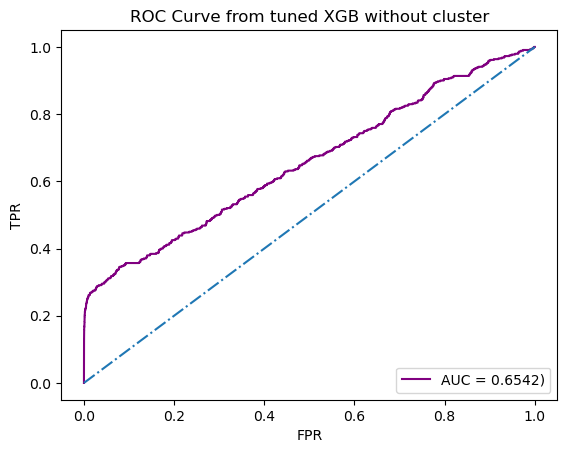

Results from tuned XGB with DBSCAN cluster:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     52441
           1       0.84      0.15      0.25       440

    accuracy                           0.99     52881
   macro avg       0.92      0.57      0.62     52881
weighted avg       0.99      0.99      0.99     52881

Confusion matrix: [[52429    12]
 [  376    64]]
ROC AUC Score: 0.648306170050845
Gini: 0.29661234010169
Precision (Fraud Label): 0.8421052631578947


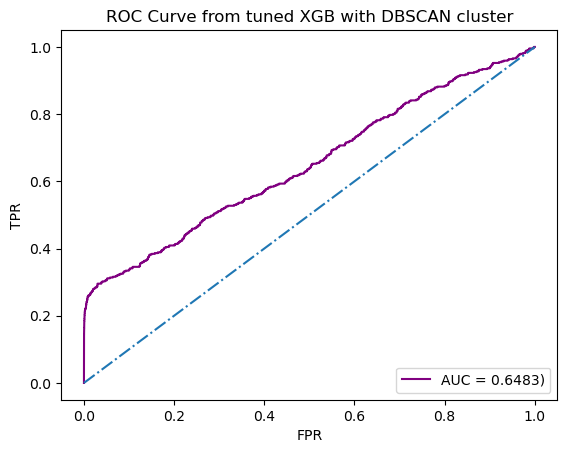

Results from tuned XGB with K-Means cluster:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     52441
           1       0.75      0.15      0.25       440

    accuracy                           0.99     52881
   macro avg       0.87      0.57      0.62     52881
weighted avg       0.99      0.99      0.99     52881

Confusion matrix: [[52419    22]
 [  374    66]]
ROC AUC Score: 0.660020156851596
Gini: 0.32004031370319197
Precision (Fraud Label): 0.75


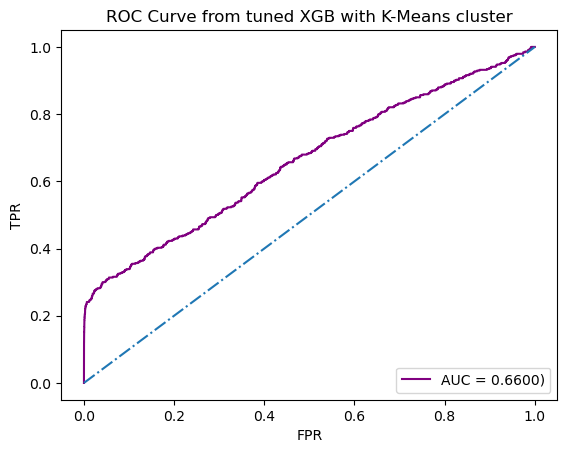

In [51]:
#update best params into model
def xgb_tuned(X, y, dt):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    
    #instantiate model
    xgb_model = XGBClassifier(random_state = 42, eval_metric = 'auc', **best_params)
    xgb_model.fit(X_train, y_train)
    
    #model prediction
    y_pred = xgb_model.predict(X_test)
    print(f'Results from {dt}:\n')
    print(classification_report(y_test, y_pred))
    print(f'Confusion matrix: {confusion_matrix(y_test, y_pred)}')
    
    #Gini calculation
    y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_prob)
    print(f'ROC AUC Score: {auc_score}')
    print(f'Gini: {auc_score * 2 - 1}')
    
    #fraud precision score calculation
    precision_fraud = precision_score(y_test, y_pred, pos_label=1)
    print(f'Precision (Fraud Label): {precision_fraud}')
    
    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, color = 'purple', label = f'AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1],  linestyle = '-.')  # Random guessing line
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'ROC Curve from {dt}')
    plt.legend(loc='lower right')
    plt.show()

    return {'sample size': len(X),
            'Confusion_matrix': confusion_matrix(y_test, y_pred),
            'AUC': auc_score,
            'Precision_fraud': precision_fraud}


XGBt_X = xgb_tuned(X, y, dt = 'tuned XGB without cluster')
XGBt_DB = xgb_tuned(X_DB, y_DB, dt = 'tuned XGB with DBSCAN cluster')
XBGt_KM = xgb_tuned(X_KM, y_KM, dt = 'tuned XGB with K-Means cluster')

After tuning params, we see K-means combines with XGBoost on best params are good combination that add in +2 gini in result.

Now we wanna test if apply K-means on larger sample size will impact to performance of XGBoost model.

### 4.5. Additional test on larger sample size to see how far K-means can do

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def CM(CX_test, CX_val):
    cm_clf1 = CX_test
    cm_clf2 = CX_val
    
    # Define class labels
    classes = ['non-fraud', 'fraud']
    
    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
    
    # Plot confusion matrix for classifier 1
    axs[0].imshow(cm_clf1, cmap='Blues', interpolation='nearest')
    axs[0].set(xticks = np.arange(cm_clf1.shape[1]),
               yticks = np.arange(cm_clf1.shape[0]),
               xticklabels = classes, yticklabels = classes,
               title = f'Confusion Matrix without cluster',
               xlabel = 'Predicted label',
               ylabel = 'True label')
    plt.setp(axs[0].get_xticklabels(), ha='right', rotation_mode= 'anchor')
    for i in range(cm_clf1.shape[0]):
        for j in range(cm_clf1.shape[1]):
            axs[0].text(j, i, format(cm_clf1[i, j], 'd'), ha = 'center', va = 'center',
                        color='white' if cm_clf1[i, j] > cm_clf1.max() / 2. else 'black')
    
    # Plot confusion matrix for classifier 2
    axs[1].imshow(cm_clf2, cmap = 'Greens', interpolation = 'nearest')
    axs[1].set(xticks = np.arange(cm_clf2.shape[1]),
               yticks = np.arange(cm_clf2.shape[0]),
               xticklabels = classes, yticklabels = classes,
               title = f'Confusion Matrix with K-means cluster',
               xlabel = 'Predicted label',
               ylabel = 'True label')
    plt.setp(axs[1].get_xticklabels(),  ha = 'right', rotation_mode = 'anchor')
    for i in range(cm_clf2.shape[0]):
        for j in range(cm_clf2.shape[1]):
            axs[1].text(j, i, format(cm_clf2[i, j], 'd'), ha = 'center', va = 'center',
                        color = 'white' if cm_clf2[i, j] > cm_clf2.max() / 2. else 'black')
    
    plt.tight_layout()
    plt.show()

Results from  0.3: tuned XGB without cluster:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     78623
           1       0.68      0.14      0.23       698

    accuracy                           0.99     79321
   macro avg       0.84      0.57      0.61     79321
weighted avg       0.99      0.99      0.99     79321

Confusion matrix: [[78579    44]
 [  603    95]]
ROC AUC Score: 0.6561445051312478
Gini: 0.31228901026249556
Precision (Fraud Label): 0.6834532374100719


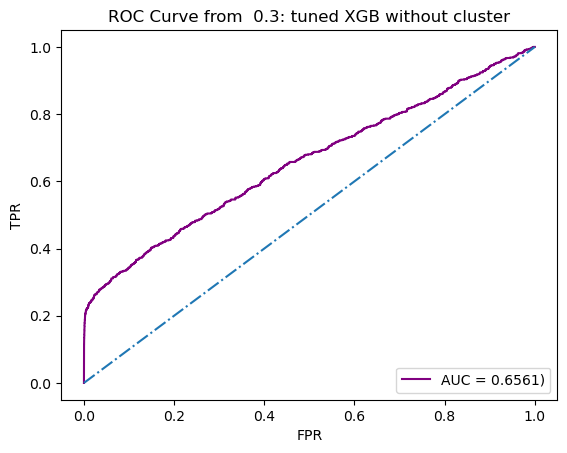

Results from  0.3: tuned XGB with K-Means cluster:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     78623
           1       0.68      0.14      0.23       698

    accuracy                           0.99     79321
   macro avg       0.84      0.57      0.61     79321
weighted avg       0.99      0.99      0.99     79321

Confusion matrix: [[78577    46]
 [  601    97]]
ROC AUC Score: 0.6533648734720299
Gini: 0.30672974694405974
Precision (Fraud Label): 0.6783216783216783


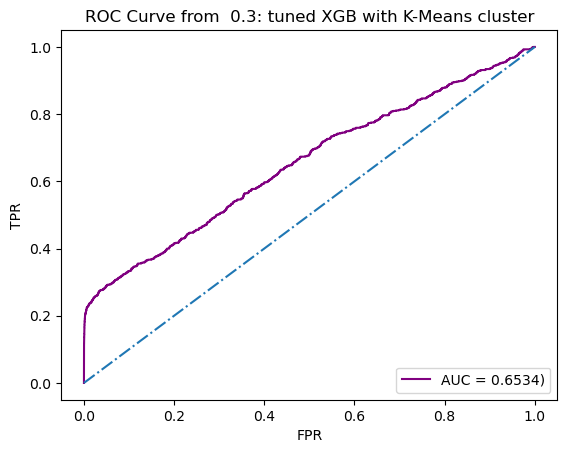

Results from  0.5: tuned XGB without cluster:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    131006
           1       0.71      0.15      0.25      1195

    accuracy                           0.99    132201
   macro avg       0.85      0.58      0.62    132201
weighted avg       0.99      0.99      0.99    132201

Confusion matrix: [[130933     73]
 [  1015    180]]
ROC AUC Score: 0.6646434156741488
Gini: 0.3292868313482975
Precision (Fraud Label): 0.7114624505928854


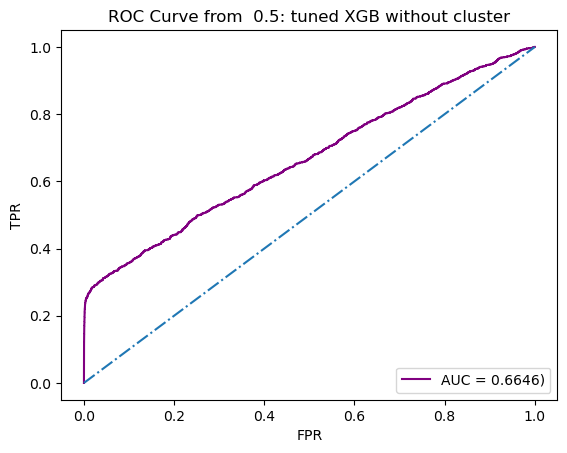

Results from  0.5: tuned XGB with K-Means cluster:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    131006
           1       0.71      0.16      0.26      1195

    accuracy                           0.99    132201
   macro avg       0.85      0.58      0.63    132201
weighted avg       0.99      0.99      0.99    132201

Confusion matrix: [[130931     75]
 [  1009    186]]
ROC AUC Score: 0.6631854192758874
Gini: 0.32637083855177473
Precision (Fraud Label): 0.7126436781609196


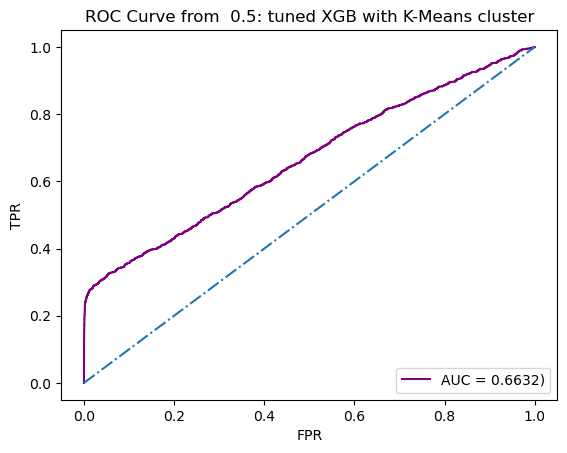

Results from  1: tuned XGB without cluster:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    262060
           1       0.73      0.15      0.25      2342

    accuracy                           0.99    264402
   macro avg       0.86      0.57      0.62    264402
weighted avg       0.99      0.99      0.99    264402

Confusion matrix: [[261933    127]
 [  1996    346]]
ROC AUC Score: 0.6576024295907359
Gini: 0.3152048591814718
Precision (Fraud Label): 0.7315010570824524


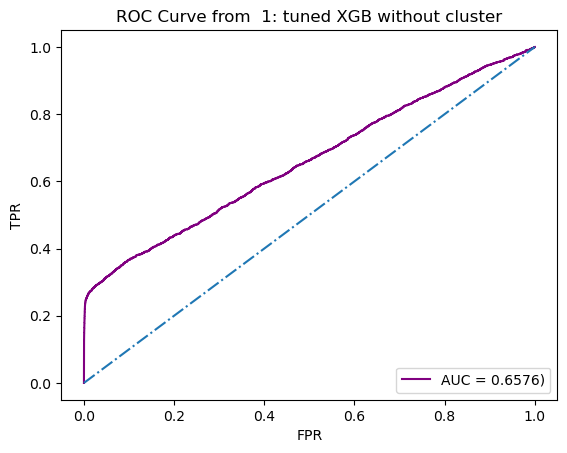

Results from  1: tuned XGB with K-Means cluster:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    262060
           1       0.75      0.15      0.25      2342

    accuracy                           0.99    264402
   macro avg       0.87      0.57      0.62    264402
weighted avg       0.99      0.99      0.99    264402

Confusion matrix: [[261945    115]
 [  1997    345]]
ROC AUC Score: 0.6651130123328841
Gini: 0.3302260246657682
Precision (Fraud Label): 0.75


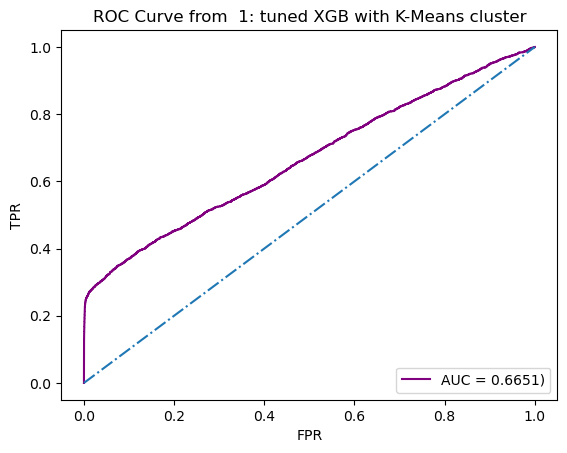

In [74]:
dict_f = {}
for f in [0.3, 0.5, 1]:
    samplef = df_train.sample(frac = f, random_state = 42)
    scaled_sampled_data_ = scaler.fit_transform(samplef[strong_f]) #scaling

    #from above iteration/tuning params for sample size at 20% of origin dataset, base on inertia we select n = 8 as observe no rapid drop on later n.
    kmeans_ = KMeans(n_clusters = 8, random_state = 42)
    kmeans_labels_ = kmeans.fit_predict(scaled_sampled_data_) #fit to scaled_data with same sample ratio of DBSCAN and predict cluster
    
    #update cluster label
    samplef['KMean_Cluster'] = kmeans_labels_

    #sample WITHOUT cluster
    Xf = samplef.drop(columns = ['TX_FRAUD', 'KMean_Cluster']).copy() #not keeping any cluster data
    yf = samplef['TX_FRAUD'].copy()

    #sample WITH cluster
    X_KMf = samplef.drop(columns = ['TX_FRAUD']).copy() #keep cluster by K-means only
    y_KMf = samplef['TX_FRAUD'].copy()

    #result for comparision
    XGBt_Xf = xgb_tuned(Xf, yf, dt = f' {f}: tuned XGB without cluster')
    XBGt_XKMf = xgb_tuned(X_KMf, y_KMf, dt = f' {f}: tuned XGB with K-Means cluster')

    dict_f[f'X{f}'] = XGBt_Xf
    dict_f[f'KM{f}'] = XBGt_XKMf
    


In [75]:
dict_f

{'X0.3': {'sample size': 264401,
  'Confusion_matrix': array([[78579,    44],
         [  603,    95]]),
  'AUC': 0.6561445051312478,
  'Precision_fraud': 0.6834532374100719},
 'KM0.3': {'sample size': 264401,
  'Confusion_matrix': array([[78577,    46],
         [  601,    97]]),
  'AUC': 0.6533648734720299,
  'Precision_fraud': 0.6783216783216783},
 'X0.5': {'sample size': 440668,
  'Confusion_matrix': array([[130933,     73],
         [  1015,    180]]),
  'AUC': 0.6646434156741488,
  'Precision_fraud': 0.7114624505928854},
 'KM0.5': {'sample size': 440668,
  'Confusion_matrix': array([[130931,     75],
         [  1009,    186]]),
  'AUC': 0.6631854192758874,
  'Precision_fraud': 0.7126436781609196},
 'X1': {'sample size': 881337,
  'Confusion_matrix': array([[261933,    127],
         [  1996,    346]]),
  'AUC': 0.6576024295907359,
  'Precision_fraud': 0.7315010570824524},
 'KM1': {'sample size': 881337,
  'Confusion_matrix': array([[261945,    115],
         [  1997,    345]]),


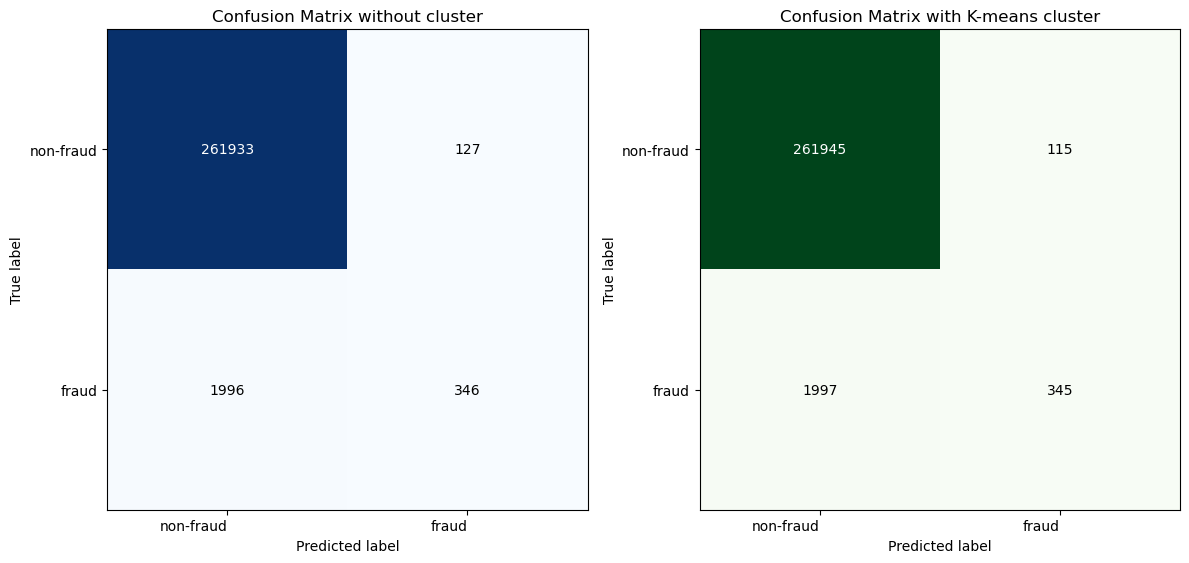

In [77]:
CM_x = dict_f['X1']['Confusion_matrix']
CM_km = dict_f['KM1']['Confusion_matrix']

CM(CM_x,CM_km)

from confusion matrix we found model with K-means cluster helps to improve classification, increase number of predicted as non-fraud case correctly, help to improve efficient for investigation (i.e perform investigation on 12 non-fraud transaction may cost ++amount) and impact to also user experience if the measure is block/failed transation, ect.
on the other hand, we observe 1 fraud case was missed when classify as non-fraud while it's a real fraud case.
In this situation, we understand 1 fraud case can cause some loss which need compensation from n cases. Thus, for this situation, we need to further analyse on cost-benefit and make decision on apply this model accordingly.

## 5. CONCLUSION

DBSCAN offers flexibility in clustering, allow new entities to reform new number of cluster and discover potential character of the new structure with high accuracy in clustering entity sharing most alike characters.  On the other hand, by this character of algo itself, require certain investment in hardware and technical resources in order to process huge data flow within short time.
Additionally, it also requires further analysis on distribution within cluster to identify if anomaly structure appeared to alert on new pattern, to understand if it associates to fraudulent entities.
K-Means is alternative option, work better in hybrid mode as a feature facilitate for supervised model afterwards. However, K-means requires given fix number of cluster, thus reduce ability of self-exploration.
Exploring usage of K-Means to build new predictive feature for XGBoost model, after tuning to best params we observe it can help to improve 1.85% fraud alert (observe via confusion matrix, reduce number of wrong classify fraud) with Gini improve from 0.315 to 0.33 indicating better ability in distinguish fraud/non-fraud transaction.

**Because the nature of business itself will need the ability to alert potential fraud event real-time while handling huge number of transaction in retails nowadays.
alternatively, business approach can also consider post-event detection and optimize investigation procedure, reduce number of false alarm and respectively reduce cost on inefficient fraud investigated activity.** 
